# Keras CIFAR10 CNN

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                                                                        
);

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);

var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
import random

def random_hue(s=100, l=80):
  return 'hsl({}, {}%, {}%)'.format(random.randint(0, 360), s, l)

color1 = random_hue(s=20, l=95)
color2 = random_hue(s=40, l=80)
css = '''
<style>
div.cell {{background-color: {color1};}}
div.running {{background-color: {color2};}}
div.running.selected {{background-color: {color2};}}
</style>'''.format(color1=color1, color2=color2)

display(HTML(css))

In [123]:
import _pickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename, astype='float'):
  """ load single batch of cifar """
  print(filename)
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(astype)
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT, n=1, astype='float'):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1, n+1):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f, astype=astype)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  # Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'), astype=astype)
  return Xtr, Ytr, # Xte, Yte


def get_CIFAR10_data(num_training=17000, num_validation=1000,
                     num_test=2000, astype='float'):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    import math
    cifar10_dir = '../CS231n_assignment2/cs231n/datasets'
    n = math.ceil((num_training + num_validation + num_test) / 10000)
    X_train, y_train = load_CIFAR10(cifar10_dir, n=int(n), astype=astype)

    # Subsample the data
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    mask = list(mask)
    X_test = X_train[mask]
    y_test = y_train[mask]

    mask = range(num_training, num_training + num_validation)
    mask = list(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]

    mask = range(num_training)
    mask = list(mask)
    X_train = X_train[mask]
    y_train = y_train[mask]

    print('X_train', X_train.shape)
    print('X_val', X_val.shape)
    print('X_test', X_test.shape)
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Transpose so that channels come first   Probe: on keras tf donot transpose
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

data = get_CIFAR10_data(num_training=19000, num_validation=1000,
                        num_test=0, astype=np.float32)

for k, v in data.items():
  print ('%s: ' % k, v.shape)

../CS231n_assignment2/cs231n/datasets/data_batch_1
../CS231n_assignment2/cs231n/datasets/data_batch_2
X_train (19000, 32, 32, 3)
X_val (1000, 32, 32, 3)
X_test (0, 32, 32, 3)
X_val:  (1000, 32, 32, 3)
X_test:  (0, 32, 32, 3)
X_train:  (19000, 32, 32, 3)
y_val:  (1000,)
y_train:  (19000,)
y_test:  (0,)


In [124]:

# from keras.datasets import cifar10
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [125]:

nb_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)


# X_train = X_train.astype('float32')
# X_val = X_val.astype('float32')
# X_train /= 255
# X_val /= 255

X_train shape: (19000, 32, 32, 3)
19000 train samples
1000 val samples


In [136]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        W_regularizer=l2(0.01),
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
# model.add(Convolution2D(32, 3, 3, W_regularizer=l2(0.01)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same', 
                        W_regularizer=l2(0.01)))
model.add(Activation('relu'))
# model.add(Convolution2D(64, 3, 3, W_regularizer=l2(0.01),))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

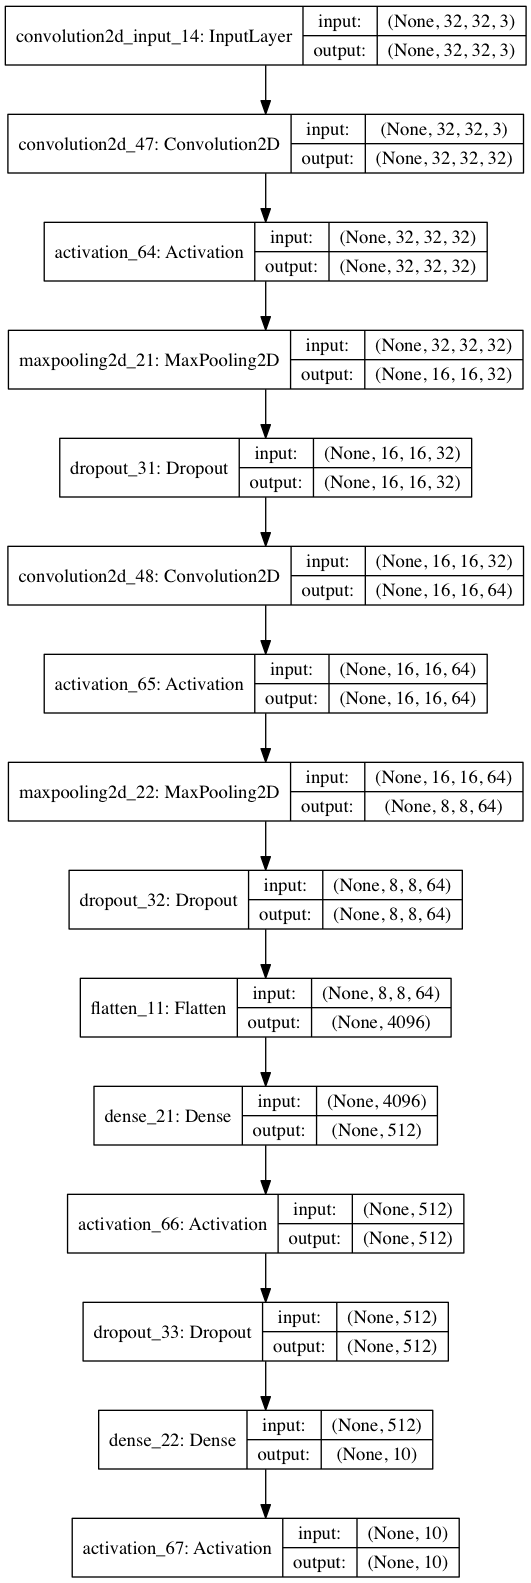

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_47 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_14[0][0]     
____________________________________________________________________________________________________
activation_64 (Activation)       (None, 32, 32, 32)    0           convolution2d_47[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 16, 16, 32)    0           activation_64[0][0]              
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 16, 16, 32)    0           maxpooling2d_21[0][0]            
___________________________________________________________________________________________

In [137]:
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, to_file='model.png')
from IPython.display import display, Image
display(Image('model.png', width=300))
print(model.summary())

In [13]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3  %%rub

In [138]:

# print(logs)
# {'size': 500, 'acc': 0.31600001, 'batch': 0, 'loss': 1.9779361}
class BatchLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_loss = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
    def on_epoch_end(self, epoch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

# init
batch_loss_history = BatchLossHistory()


In [145]:
nb_epoch = 9
batch_size = 1000

# import keras
# adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
# model.compile(loss='categorical_crossentropy', 
#               optimizer=rms,
#               metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
                 batch_size=batch_size,
                 nb_epoch=nb_epoch,
                 validation_data=(X_val, Y_val),
                 shuffle=True,
                 verbose=1,
                 callbacks=[batch_loss_history],
                 )

# 如果 train record 加到 35000, 可以比较轻松的达到 val_acc 65%

# 如果简化 Conv 层, 训练加快, 但是不稳, val_acc 浮动很大
# Epoch 2/9
# 19000/19000 48s - loss: 1.6353 - acc: 0.5947 - val_loss: 1.7525 - val_acc: 0.5610
# Epoch 3/9
# 19000/19000 47s - loss: 1.4281 - acc: 0.6377 - val_loss: 1.5567 - val_acc: 0.5880
# Epoch 4/9
# 19000/19000 49s - loss: 1.4583 - acc: 0.6272 - val_loss: 1.5028 - val_acc: 0.6070
# Epoch 5/9
# 19000/19000 47s - loss: 1.7072 - acc: 0.5813 - val_loss: 2.1053 - val_acc: 0.4370
# Epoch 6/9
# 19000/19000 47s - loss: 1.8018 - acc: 0.5693 - val_loss: 1.4716 - val_acc: 0.6300
# ...

Train on 19000 samples, validate on 1000 samples
Epoch 1/9
19000/19000 [==============================] - 48s - loss: 1.4381 - acc: 0.6215 - val_loss: 1.6005 - val_acc: 0.5690
Epoch 2/9
19000/19000 [==============================] - 48s - loss: 1.6353 - acc: 0.5947 - val_loss: 1.7525 - val_acc: 0.5610
Epoch 3/9
19000/19000 [==============================] - 47s - loss: 1.4281 - acc: 0.6377 - val_loss: 1.5567 - val_acc: 0.5880
Epoch 4/9
19000/19000 [==============================] - 49s - loss: 1.4583 - acc: 0.6272 - val_loss: 1.5028 - val_acc: 0.6070
Epoch 5/9
19000/19000 [==============================] - 47s - loss: 1.7072 - acc: 0.5813 - val_loss: 2.1053 - val_acc: 0.4370
Epoch 6/9
19000/19000 [==============================] - 47s - loss: 1.8018 - acc: 0.5693 - val_loss: 1.4716 - val_acc: 0.6300
Epoch 7/9
19000/19000 [==============================] - 47s - loss: 1.5297 - acc: 0.6131 - val_loss: 1.4746 - val_acc: 0.6380
Epoch 8/9
19000/19000 [==============================] - 49s -

In [ ]:
# for data augmentation
# not used for now

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train,
                                     batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_val, Y_val))

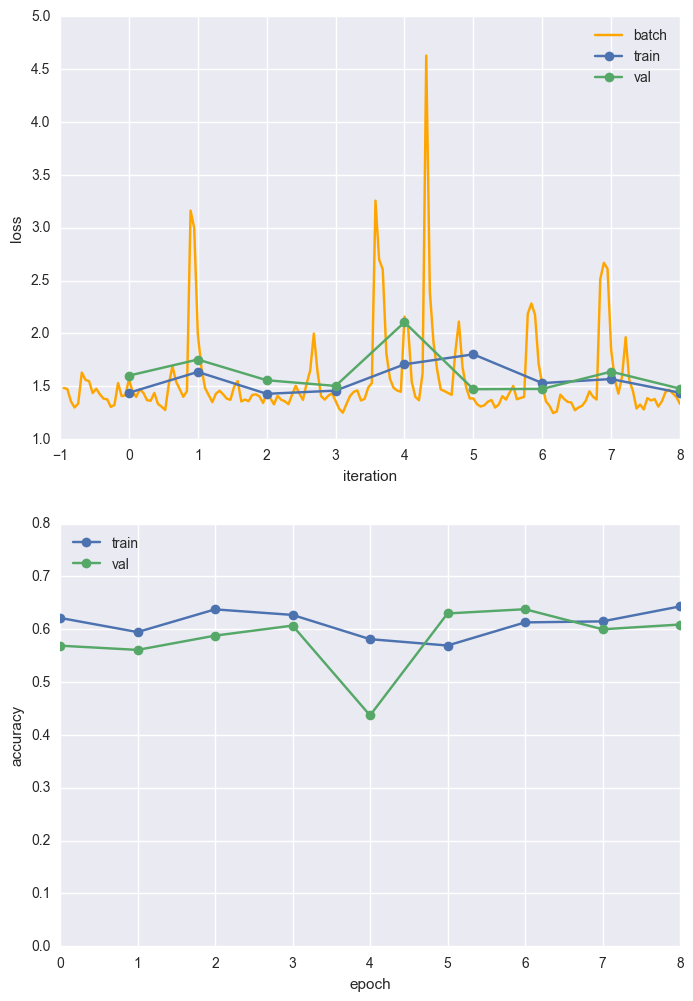

In [146]:
plt.subplot(2, 1, 1)

epochs = len(batch_loss_history.train_loss)
batchs = len(batch_loss_history.batch_loss)
batchs_per_epoch = batchs/epochs
xs = np.arange(0, batchs)/batchs*epochs-(1-1/batchs_per_epoch)
plt.plot(xs, batch_loss_history.batch_loss, '-', color='orange')
plt.plot(batch_loss_history.train_loss, '-o')
plt.plot(batch_loss_history.val_loss, '-o')
plt.legend(['batch', 'train', 'val'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

ax = plt.subplot(2, 1, 2)
plt.plot(batch_loss_history.train_acc, '-o')
plt.plot(batch_loss_history.val_acc, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
ax.set_ylim((0.0, 0.8))
plt.show()